In [288]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt

In [289]:
def majority_rule(value_1, value_2, df):
    values = np.zeros(2)
    for i in range(len(df)):
        row = df.loc[i, :].values
        num_votes = row[0]
        i_1 = np.where(row == value_1)
        i_2 = np.where(row == value_2)
        if i_1 < i_2:
            #value_1 is prefered to value_2
            values[0]+= num_votes
        else:
            #value_2 is prefered to value_1
            values[1]+= num_votes

    if values[0] > values[1]:
        return value_1
    else:
        return value_2

In [290]:
def plurality(df):
    
    #look at only the data of preference 1
    pref_1 = df[df.columns[1]]
    num_votes = df[df.columns[0]]
    result = []
    
    my_dict = dict() #this dictionary holds {candidates: # votes}
    for i in range(len(pref_1)):
        if pref_1[i] in my_dict:
            my_dict[pref_1[i]] += num_votes[i]
        else:
            my_dict[pref_1[i]] = num_votes[i]
    
    return max(my_dict, key=my_dict.get)

In [291]:
def plurality_runoff(df):
    
    #look at only the data of preference 1
    pref_1 = df[df.columns[1]]
    num_votes = df[df.columns[0]]
    result = []
    
    my_dict = dict() #this dictionary holds {candidates: # votes}
    for i in range(len(pref_1)):
        if pref_1[i] in my_dict:
            my_dict[pref_1[i]] += num_votes[i]
        else:
            my_dict[pref_1[i]] = num_votes[i]
    
    first = max(my_dict, key=my_dict.get)
    #check if its > 50 %
    if (my_dict[first]/np.sum(num_votes)) > 0.5:
        return first
    else:        
        my_dict.pop(first)
        second = max(my_dict, key=my_dict.get)
        print("Pluraty run off: After the first round, following candidates remain")
        print("First: ", first)
        print("Second:", second)
        
        return majority_rule(first, second, df)

In [292]:
def topological_sorting(matrix):
    """This is a helper function to help condorcet voting"""
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    #find the number of in-degrees for each vertex (the sum of elements per column)
    in_degrees = [0] * cols
    for i in range(rows):
        for j in range(cols):
            in_degrees[j]+=matrix[i][j]
    #number of already visited nodes
    visited_nodes=0
    #queue of the visited nodes
    queue = []
    #queue for the output nodes
    output_queue = []
    #add the nodes with in-degree 0 to the queue
    for i in range(cols):
        if in_degrees[i]==0:
            queue.append(i)
    #for each element visited Increment count of visited nodes by 1. Then decrease in-degree by 1 for all its neighboring nodes.
    while queue!=[]:
        element_being_visited=queue.pop(0)
        output_queue.append(element_being_visited)
        visited_nodes+=1
        for j in range(cols):
            if matrix[element_being_visited][j]==1:
                in_degrees[j]-=1
    # If the in-degree of a neighboring nodes is reduced to zero, then add it to the queue
                if in_degrees[j]==0:
                    queue.append(j)
    #If count of visited nodes is not equal to the number of nodes in the graph then the topological sort is not possible 
    #for the given graph.
    if visited_nodes!=cols:
        #print("Topological ordering isn't possible for this graph")
        return None
    else: 
        #print("The topological sorting for the following relation would be: "))
        return output_queue

In [293]:
#Vizualize the matrix as a directed graph
def show_graph_with_labels(adjacency_matrix):
    """Helper function to visualize graph"""
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=1000, with_labels=True)
    plt.show()


In [294]:
def condorcet_voting(df):
    """returns the winner by condorcet voting rule
    can be done by topological sort"""

    # find the unique values in df
    values = []
    for col in df.columns[1:]:
        vals = np.unique(df[col].values)
        values = np.append(values, vals)
    distinct_values = np.unique(values)
    
    preference_matrix = np.zeros([len(distinct_values), len(distinct_values)])
    # create a preference matrix
    for i in range(len(distinct_values)):
        for j in range(i, len(distinct_values)):
            pref = majority_rule(distinct_values[i], distinct_values[j], df)
            if i!=j:
                if pref == distinct_values[i]:
                    preference_matrix[i][j] = 1
                else:
                    preference_matrix[j][i] = 1
    
    print("Preference Matrix:")
    print(preference_matrix)
    show_graph_with_labels(preference_matrix)
    top_result = topological_sorting(preference_matrix)
    if top_result == None:
        return None
    return distinct_values[top_result[0]]

In [295]:
def borda_voting(df):
    my_dict = dict() #this dictionary holds {candidates: # votes}
    for i in range(len(df)):
        row = df.loc[i, :].values
        num_votes = row[0]
        for j in range(1,len(row)):
            if row[j] in my_dict:
                my_dict[row[j]] += j*num_votes
            else:
                my_dict[row[j]] = j*num_votes
        
    #return the key which has minimum value
    print("The borda score is ", my_dict)
    return min(my_dict, key=my_dict.get)
        

In [296]:
#read the test data
df = pd.DataFrame([[5, 'a', 'b', 'c', 'd'],
 [4, 'a', 'c', 'b', 'd'],
 [2, 'd', 'b', 'a', 'c'],
 [6, 'd', 'b', 'c', 'a'],
 [8, 'c', 'b', 'a', 'd'],
 [2, 'd', 'c', 'b', 'a']], columns=['num_votes', 'pref_1', 'pref_2', 'pref_3', 'pref_4'])
print(df)

   num_votes pref_1 pref_2 pref_3 pref_4
0          5      a      b      c      d
1          4      a      c      b      d
2          2      d      b      a      c
3          6      d      b      c      a
4          8      c      b      a      d
5          2      d      c      b      a


In [306]:
print("Winner by plurality: ", plurality(df))

_df = pd.DataFrame([[10, 'a', 'b', 'c'], [6, 'b', 'c', 'a'], [5, 'c', 'b', 'a']])
print("\nAnother Example\n", _df)
print("Winner by plurality: ", plurality(_df))

Winner by plurality:  d

Another Example
     0  1  2  3
0  10  a  b  c
1   6  b  c  a
2   5  c  b  a
Winner by plurality:  a


In [307]:
print("Winner by plurality run off: ", plurality_runoff(df))
_df = pd.DataFrame([[10, 'a', 'b', 'c'], [6, 'b', 'c', 'a'], [5, 'c', 'b', 'a']])
print("\nAnother Example\n", _df)
print("Winner by plurality run off: ", plurality_runoff(_df))

Pluraty run off: After the first round, following candidates remain
First:  d
Second: a
Winner by plurality run off:  a

Another Example
     0  1  2  3
0  10  a  b  c
1   6  b  c  a
2   5  c  b  a
Pluraty run off: After the first round, following candidates remain
First:  a
Second: b
Winner by plurality run off:  b


Preference Matrix:
[[0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]]


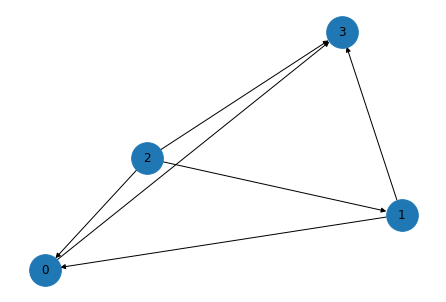

Winner by Condorcet:  c

Another Example
     0  1  2  3
0  10  a  b  c
1   6  b  c  a
2   5  c  b  a
Preference Matrix:
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]


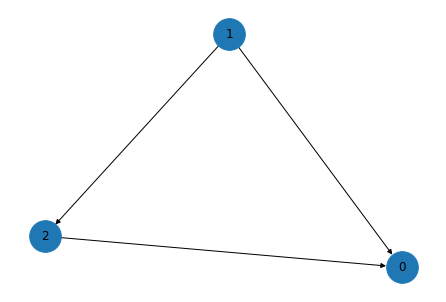

Winner by plurality run off:  b

Example where condorcet shouldn't work:
Preference Matrix:
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


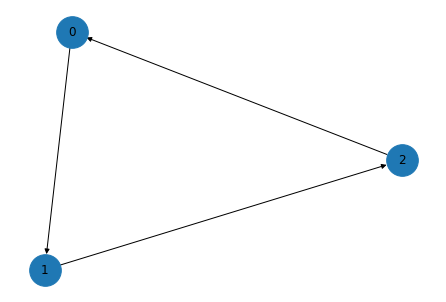

There is no condorcet winner


In [309]:
result = condorcet_voting(df)
if result != None:
    print("Winner by Condorcet: ", result)
else:
    print("There is no condorcet winner")

_df = pd.DataFrame([[10, 'a', 'b', 'c'], [6, 'b', 'c', 'a'], [5, 'c', 'b', 'a']])
print("\nAnother Example\n", _df)
print("Winner by Condorcet: ", condorcet_voting(_df))

print("\nExample where condorcet shouldn't work:")

_df = pd.DataFrame([[1, 'a', 'b', 'c'], 
                   [1, 'b', 'c', 'a'],
                   [1, 'c', 'a', 'b']])
if condorcet_voting(_df) == None:
    print("There is no condorcet winner")
    


In [310]:
print("Winner by Bording voting rule: ", borda_voting(df))

print("\nAnother example for Borda")

_df = pd.DataFrame([[2, 'b', 'a', 'c', 'd'],
            [1, 'a', 'c', 'd', 'b']])
print(_df)
print("Winner by Bording voting rule: ", borda_voting(_df))

The borda score is  {'a': 71, 'b': 60, 'c': 61, 'd': 78}
Winner by Bording voting rule:  b

Another example for Borda
   0  1  2  3  4
0  2  b  a  c  d
1  1  a  c  d  b
The borda score is  {'b': 6, 'a': 5, 'c': 8, 'd': 11}
Winner by Bording voting rule:  a

Another Example
     0  1  2  3
0  10  a  b  c
1   6  b  c  a
2   5  c  b  a
Pluraty run off: After the first round, following candidates remain
First:  a
Second: b
Winner by plurality run off:  b
